In [35]:
import pygeohash as gh
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2

sys.path.append(os.path.dirname(sys.path[0]))

from uk_road_safety.python.data_cleaning import prepare_data_for_groupby
from uk_road_safety.python.grouped_data import data_for_analysis
from uk_road_safety.python import mlmodel
import tensorflow as tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/preprocessed-1999-2021.csv')

In [12]:
df_accidents['date']=pd.to_datetime(df_accidents['date'])

In [24]:
time_series_all=data_for_analysis(df_accidents,'W')

# First Geohash gcpvj0

In [128]:
test_max_square=df_accidents[df_accidents['geohash']=='gcpvj0']
time_series_gcpvj0=data_for_analysis(test_max_square,'M')

In [232]:
FOLD_LENGTH=180 #each fold spans over 15 years
FOLD_STRIDE=12 #we have a fold every 6 months
INPUT_LENGTH=6 #every X_i sequence is 1 year
TRAIN_TEST_RATIO=.80 #in each fold, we use 3 years for training and 1 year for test
OUTPUT_LENGTH=6 #we want to predict the number of accidents in the next 6 months (y_i length)
SEQUENCE_STRIDE = 1

In [233]:
folds=mlmodel.get_folds(time_series_gcpvj0,FOLD_LENGTH,FOLD_STRIDE)
np.array(folds).shape

(8, 180, 1)

In [236]:
fold=folds[-1]

In [237]:
fold

,Accidents
date,
2006-01-31,7
2006-02-28,7
2006-03-31,7
2006-04-30,5
2006-05-31,5
...,...
2020-08-31,5
2020-09-30,5
2020-10-31,2


In [238]:
(fold_train, fold_test) = mlmodel.train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)
fold_train.shape
columns=fold_train.columns

In [239]:
scaler=MinMaxScaler()
fold_train=pd.DataFrame(scaler.fit_transform(fold_train),columns=columns)
fold_test=pd.DataFrame(scaler.transform(fold_test),columns=columns)

In [240]:
X_train_scaled, y_train_scaled = mlmodel.get_X_y_strides(fold_train,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)
X_test_scaled, y_test_scaled = mlmodel.get_X_y_strides(fold_test,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)

In [241]:
X_train_scaled.shape

(133, 6, 1)

In [242]:
y_train=y_train_scaled
y_test=y_test_scaled

In [243]:
for i,y in enumerate(y_train_scaled):
    y_train[i]=(scaler.inverse_transform(y))
for i,y in enumerate(y_test_scaled):
    y_test[i]=(scaler.inverse_transform(y))

In [244]:
y_test=y_test.astype(int)
y_train=y_train.astype(int)

In [245]:
model = mlmodel.init_model(X_train_scaled)
model.summary()

Model: "sequential_293"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_147 (LSTM)             (None, 6, 120)            58560     
                                                                 
 dense_441 (Dense)           (None, 6, 20)             2420      
                                                                 
 dropout_294 (Dropout)       (None, 6, 20)             0         
                                                                 
 dense_442 (Dense)           (None, 6, 10)             210       
                                                                 
 dropout_295 (Dropout)       (None, 6, 10)             0         
                                                                 
 dense_443 (Dense)           (None, 6, 1)              11        
                                                                 
Total params: 61,201
Trainable params: 61,201
Non-tr

In [246]:
model, history = mlmodel.fit_model(model,X_train_scaled,y_train)

Epoch 1/500
6/6 [==============================] - 4s 135ms/step - loss: 51.8559 - mae: 6.6397 - val_loss: 47.7595 - val_mae: 6.3927
Epoch 2/500
6/6 [==============================] - 0s 26ms/step - loss: 50.3262 - mae: 6.5234 - val_loss: 45.6025 - val_mae: 6.2223
Epoch 3/500
6/6 [==============================] - 0s 32ms/step - loss: 47.8563 - mae: 6.3366 - val_loss: 42.2619 - val_mae: 5.9467
Epoch 4/500
6/6 [==============================] - 0s 27ms/step - loss: 43.6411 - mae: 5.9840 - val_loss: 36.2934 - val_mae: 5.4019
Epoch 5/500
6/6 [==============================] - 0s 29ms/step - loss: 36.8955 - mae: 5.3470 - val_loss: 26.8471 - val_mae: 4.3994
Epoch 6/500
6/6 [==============================] - 0s 31ms/step - loss: 31.2059 - mae: 4.7422 - val_loss: 23.7523 - val_mae: 4.0812
Epoch 7/500
6/6 [==============================] - 0s 28ms/step - loss: 30.6472 - mae: 4.6095 - val_loss: 22.4078 - val_mae: 3.9247
Epoch 8/500
6/6 [==============================] - 0s 25ms/step - loss: 27.

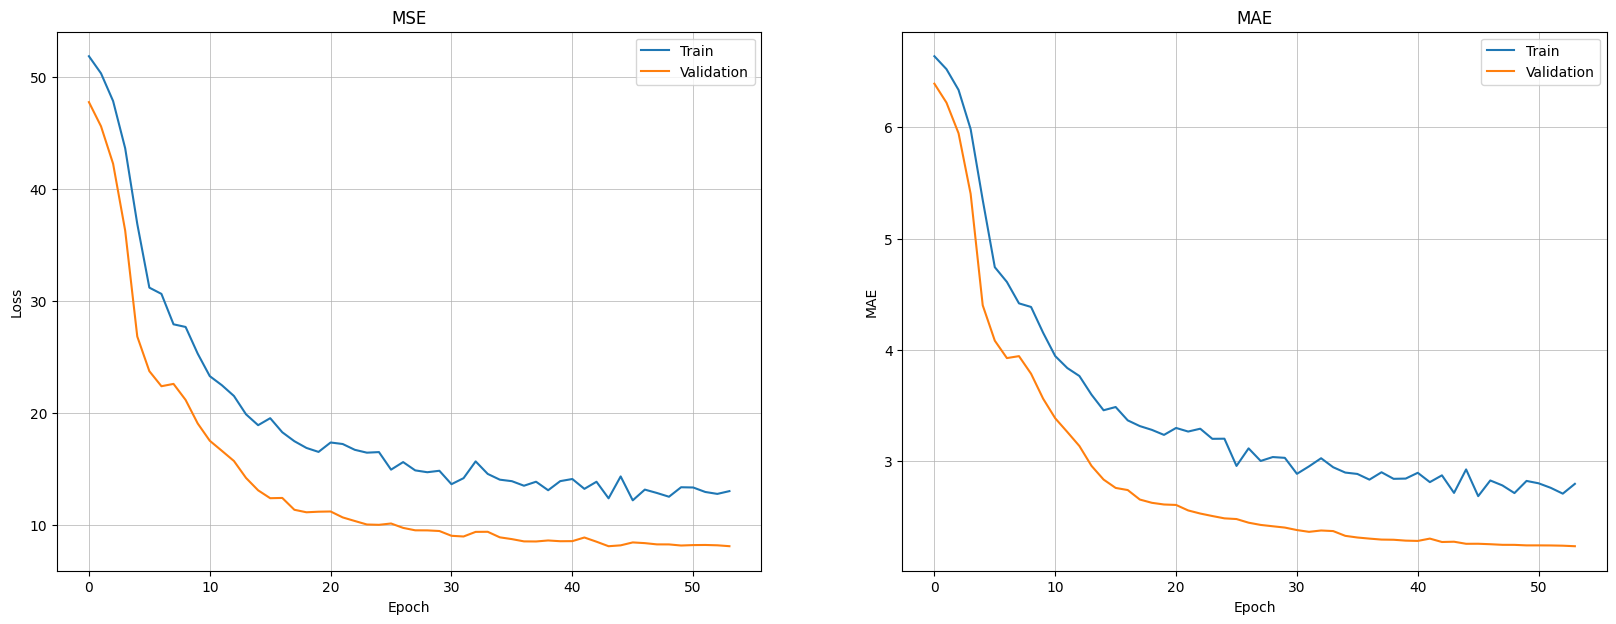

In [247]:
mlmodel.plot_history(history);

In [248]:
baseline_model = mlmodel.init_baseline(OUTPUT_LENGTH)
baseline_score = baseline_model.evaluate(X_test_scaled, y_test_scaled)
res=model.evaluate(X_test_scaled,y_test_scaled)

1/1 [==============================] - 1s 555ms/step - loss: 9.3897 - mae: 2.4531


In [249]:
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} accidents")
print(f"Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/baseline_score[1]))*100,2)} %")

The LSTM MAE on the test set is equal to 2.45 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = : 47.88 %


In [250]:
mae_baselines, mae_lstms = mlmodel.cross_validate_baseline_and_lstm(time_series_gcpvj0,FOLD_LENGTH, FOLD_STRIDE,
                                     TRAIN_TEST_RATIO, INPUT_LENGTH,
                                     OUTPUT_LENGTH, SEQUENCE_STRIDE)

8
--------------------------------------------------
MAE baseline fold n°0 = 7.33
MAE LSTM fold n°0 = 3.87
Improvement over baseline: 47.21 % 

--------------------------------------------------
MAE baseline fold n°1 = 6.59
MAE LSTM fold n°1 = 2.91
Improvement over baseline: 55.78 % 

--------------------------------------------------
MAE baseline fold n°2 = 6.62
MAE LSTM fold n°2 = 2.66
Improvement over baseline: 59.79 % 

--------------------------------------------------
MAE baseline fold n°3 = 5.83
MAE LSTM fold n°3 = 3.84
Improvement over baseline: 34.24 % 

--------------------------------------------------
MAE baseline fold n°4 = 6.24
MAE LSTM fold n°4 = 4.14
Improvement over baseline: 33.58 % 

--------------------------------------------------
MAE baseline fold n°5 = 6.22
MAE LSTM fold n°5 = 2.96
Improvement over baseline: 52.46 % 

--------------------------------------------------
MAE baseline fold n°6 = 6.2
MAE LSTM fold n°6 = 4.1
Improvement over baseline: 33.9 % 

-------

In [251]:
print(f"➡ Average percentage improvement over baseline = {round(np.mean(1 - np.array(mae_lstms)/np.array(mae_baselines)),2)*100}%")

➡ Average percentage improvement over baseline = 43.0%


1/1 [==============================] - 0s 51ms/step


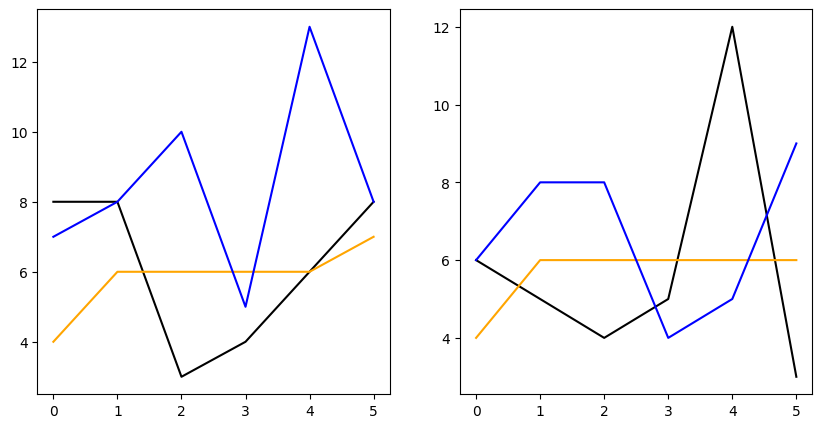

In [252]:
y_pred=model.predict(X_test_scaled)
y_bas_pred=[scaler.inverse_transform(y) for y in baseline_model.predict(X_test_scaled)]
mlmodel.plot_predictions(y_test, y_pred, y_bas_pred)

In [256]:
X_end_2021=scaler.transform(time_series_gcpvj0[-6:])
model.predict([X_end_2021]).astype(int)

1/1 [==============================] - 0s 30ms/step


array([[[4]],

       [[3]],

       [[3]],

       [[3]],

       [[4]],

       [[3]]])

# Procedure that generates one model per geohash

In [16]:
df_accidents_2021=df_accidents[df_accidents['accident_year']==2021]
hashes_2021=df_accidents[['accident_year','geohash']].groupby('geohash').count()
hashes_2021.columns=['Accidents']
hashes_2021.sort_values('Accidents',inplace=True,ascending=False)

In [17]:
geohash_list=hashes_2021.head().index
geohash_list

Index(['gcpvj0', 'gcpvhc', 'gcpvj4', 'gcpvj1', 'gcpuv2'], dtype='object', name='geohash')

******
 Initiating procedure on geohash gcpvj0
 ******
2/2 [==============================] - 0s 7ms/step - loss: 1.3640 - mae: 0.8721
The LSTM MAE on the test set is equal to 0.71 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = :18.98 %
2/2 [==============================] - 0s 3ms/step


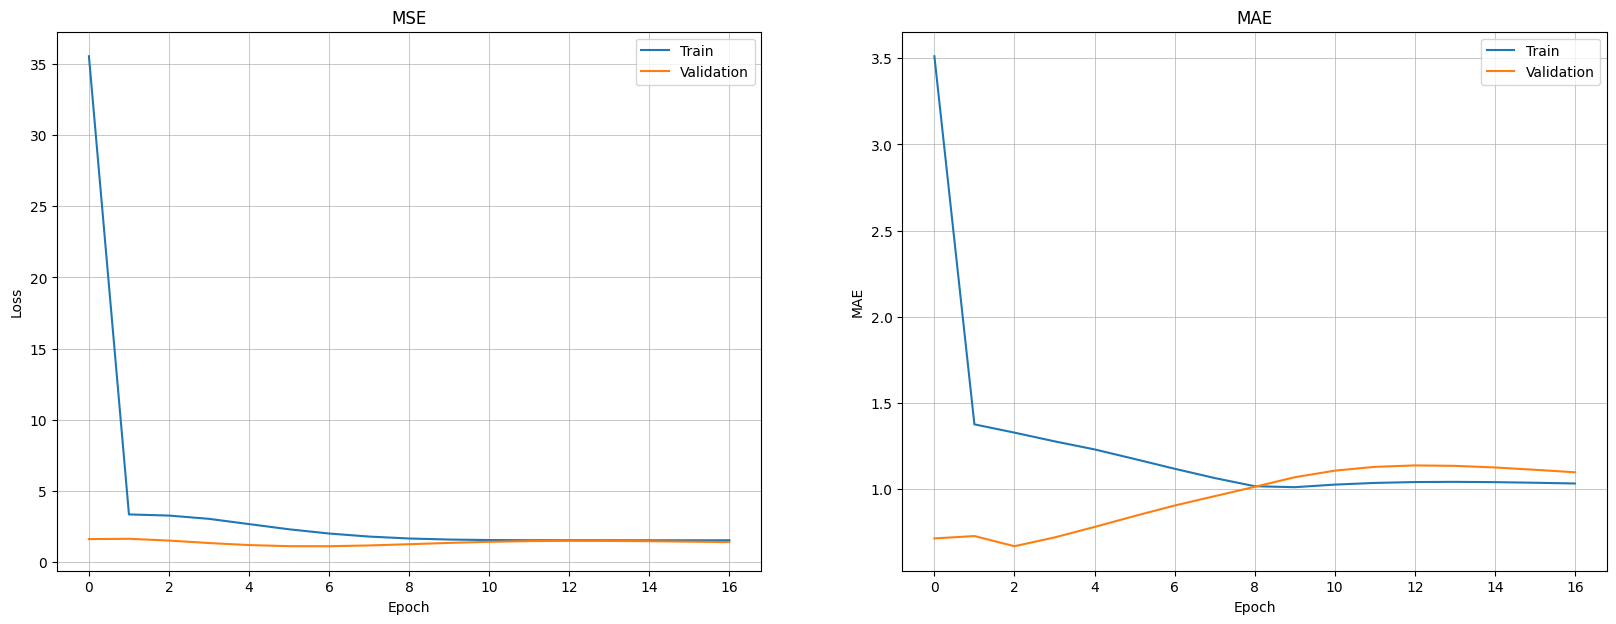

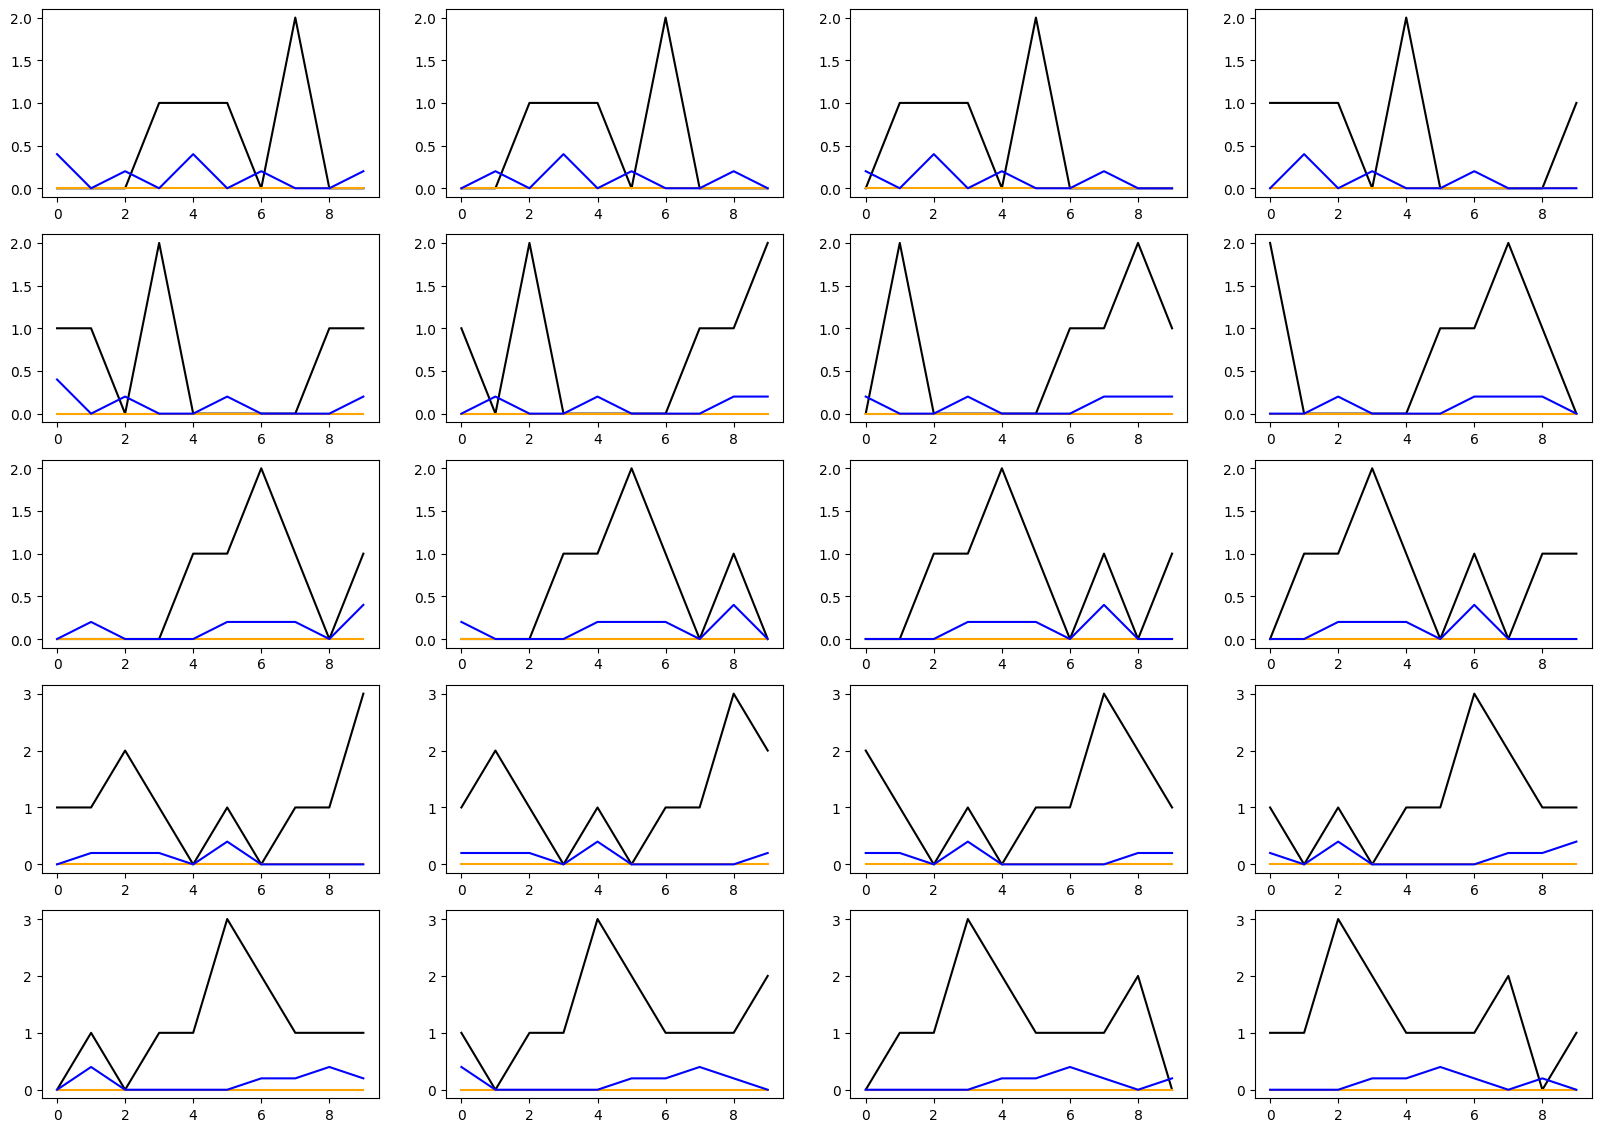

INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvj0/assets


INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvj0/assets


******
 Initiating procedure on geohash gcpvhc
 ******
2/2 [==============================] - 0s 5ms/step - loss: 1.4596 - mae: 0.8222
The LSTM MAE on the test set is equal to 0.77 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = :5.97 %
2/2 [==============================] - 0s 4ms/step


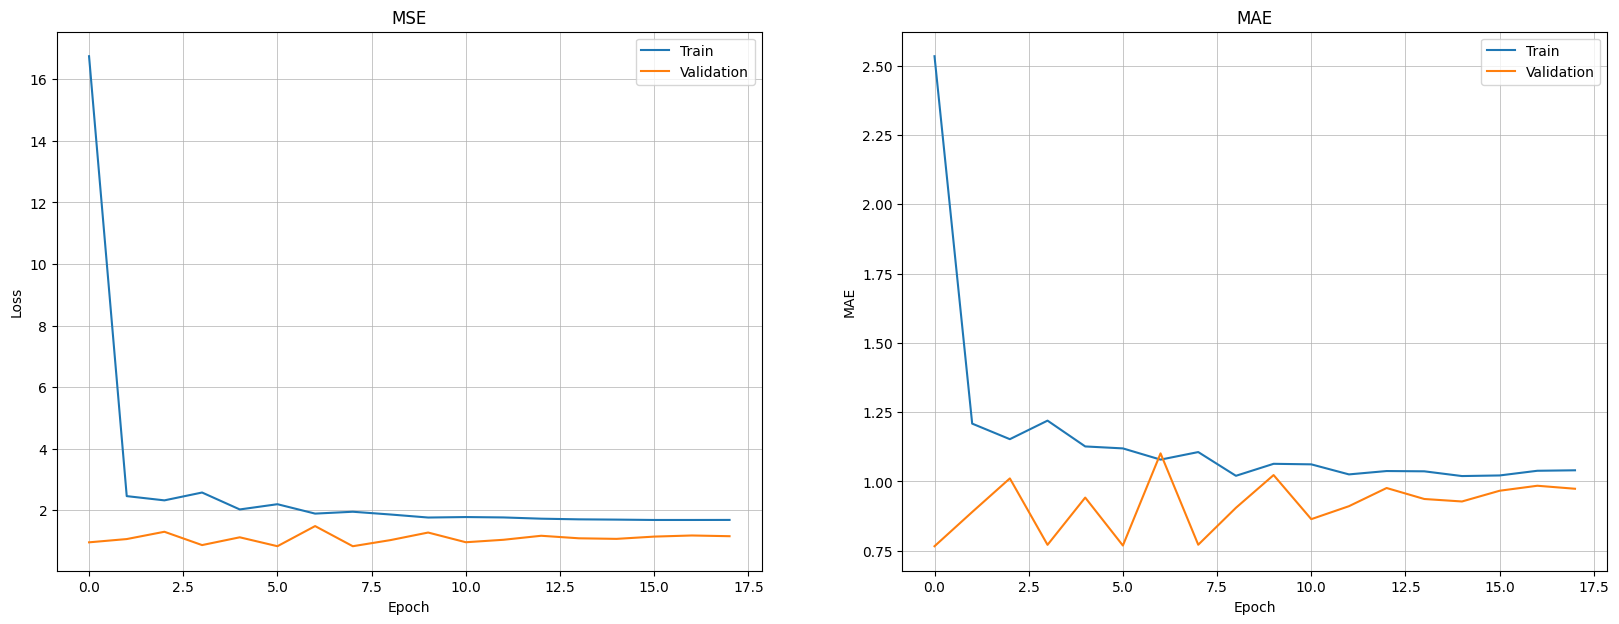

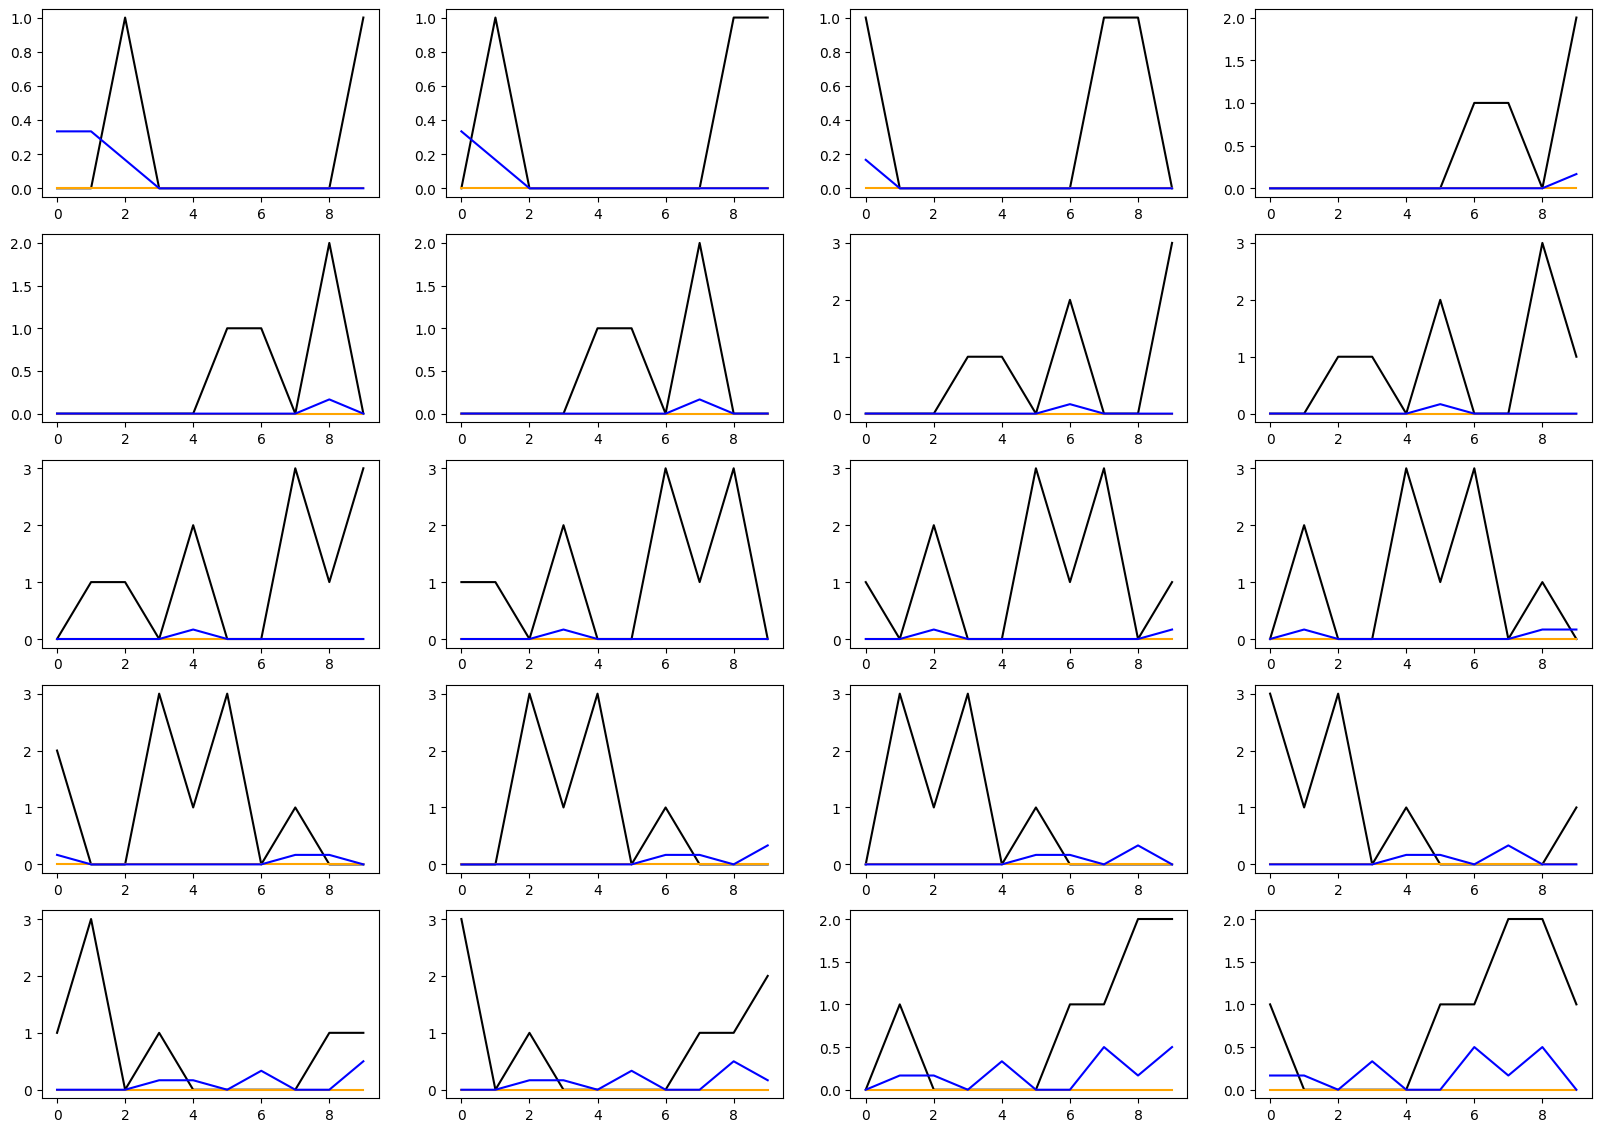

INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvhc/assets


INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvhc/assets


******
 Initiating procedure on geohash gcpvj4
 ******
2/2 [==============================] - 0s 6ms/step - loss: 1.4343 - mae: 0.8491
The LSTM MAE on the test set is equal to 0.79 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = :6.45 %
2/2 [==============================] - 0s 4ms/step


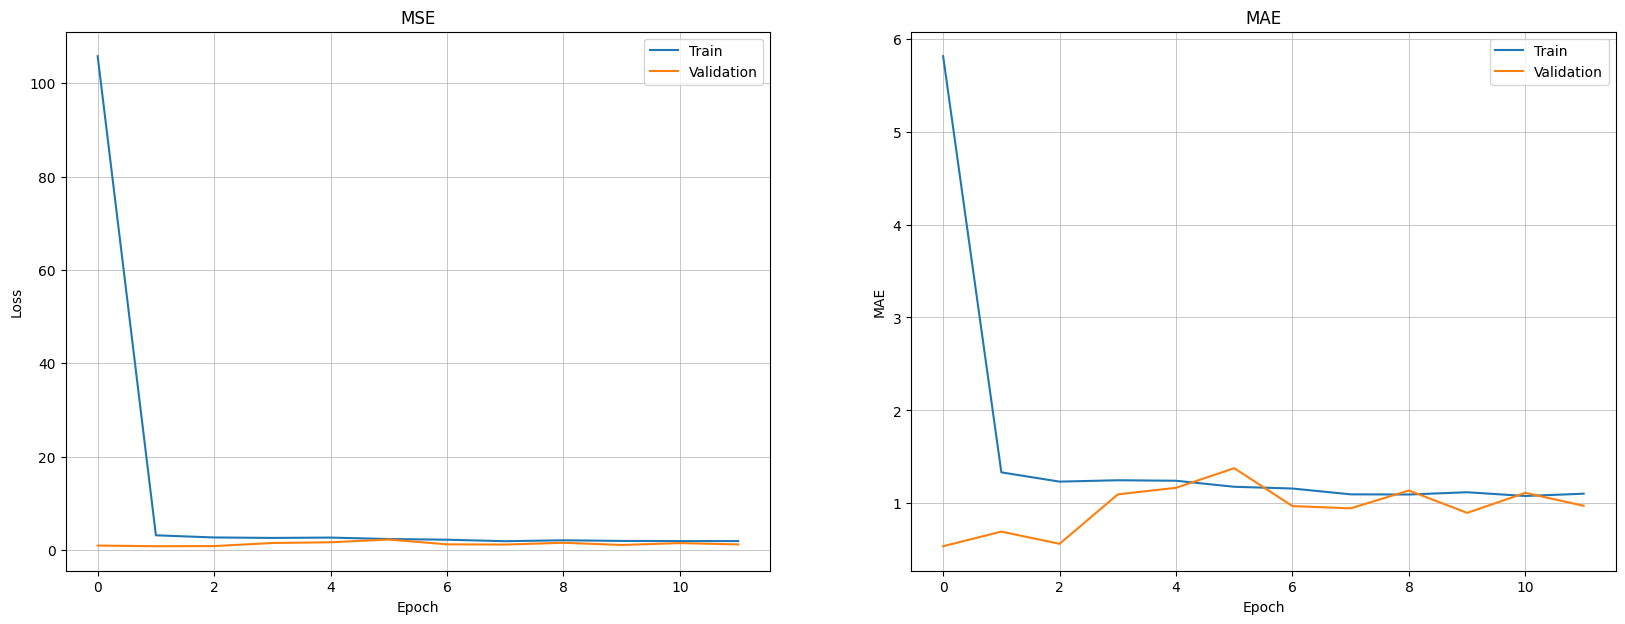

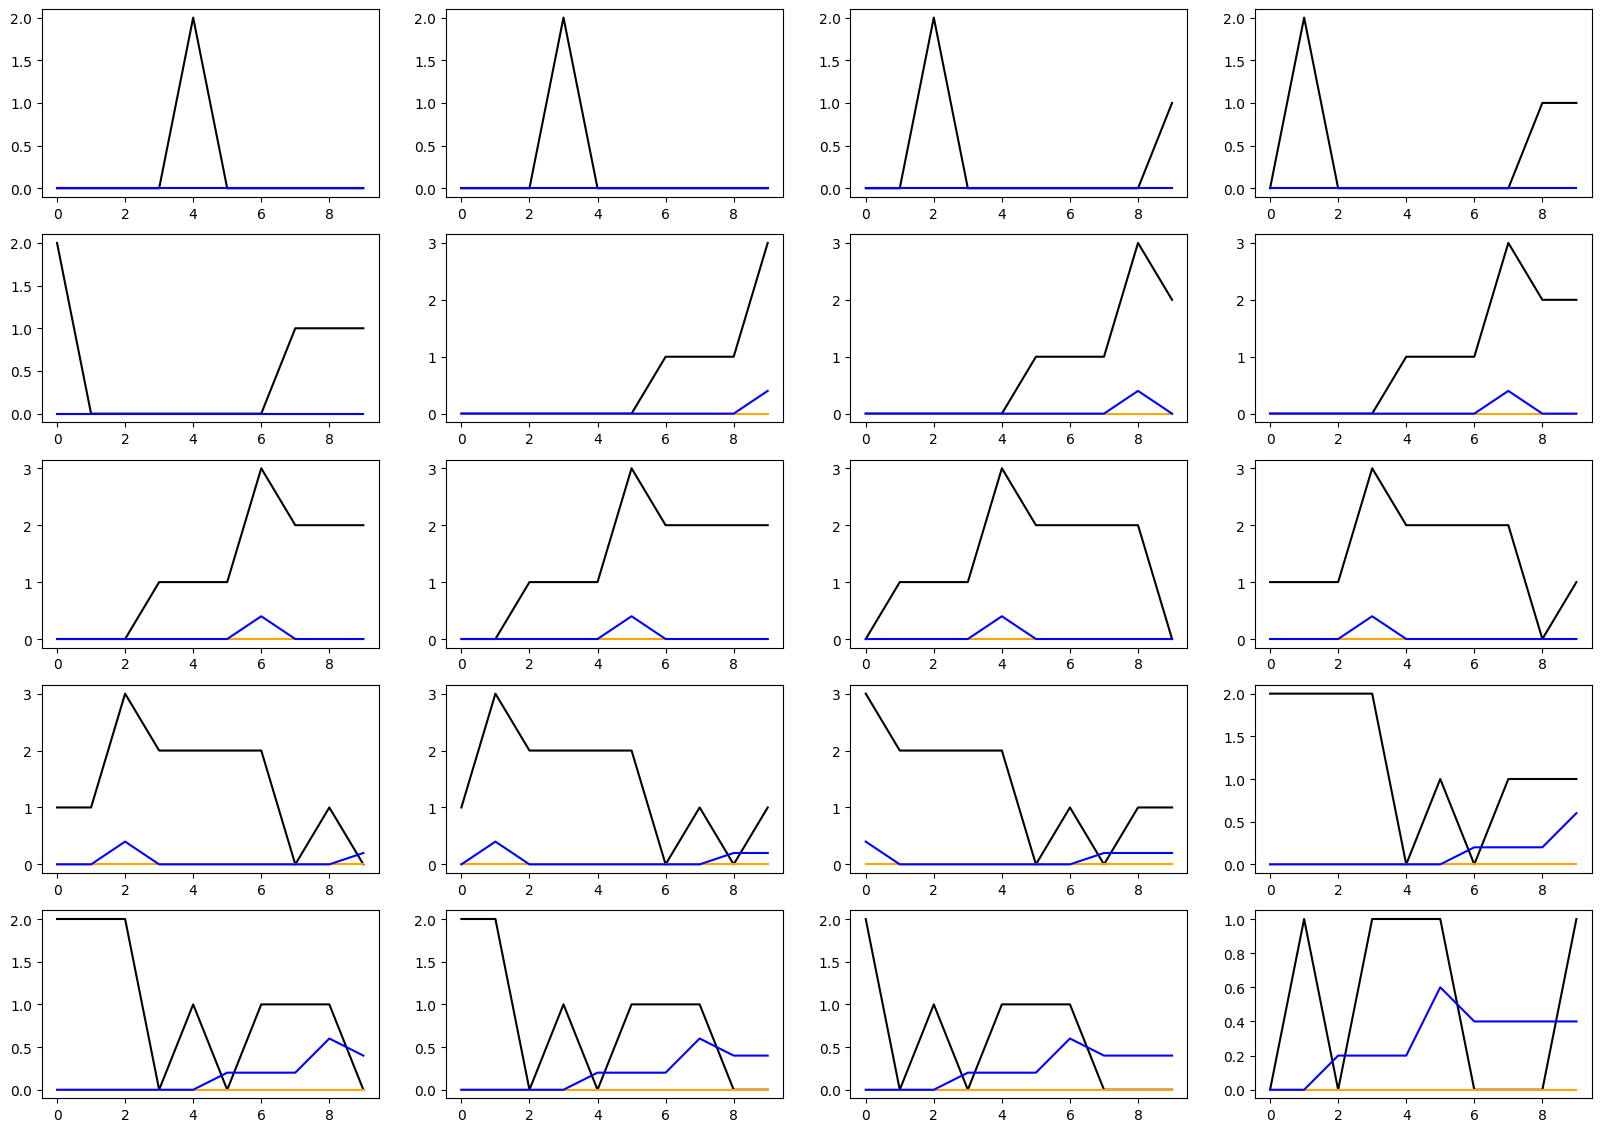

INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvj4/assets


INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvj4/assets


******
 Initiating procedure on geohash gcpvj1
 ******
2/2 [==============================] - 0s 6ms/step - loss: 1.5826 - mae: 0.7652
The LSTM MAE on the test set is equal to 0.76 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = :0.08 %
2/2 [==============================] - 0s 3ms/step


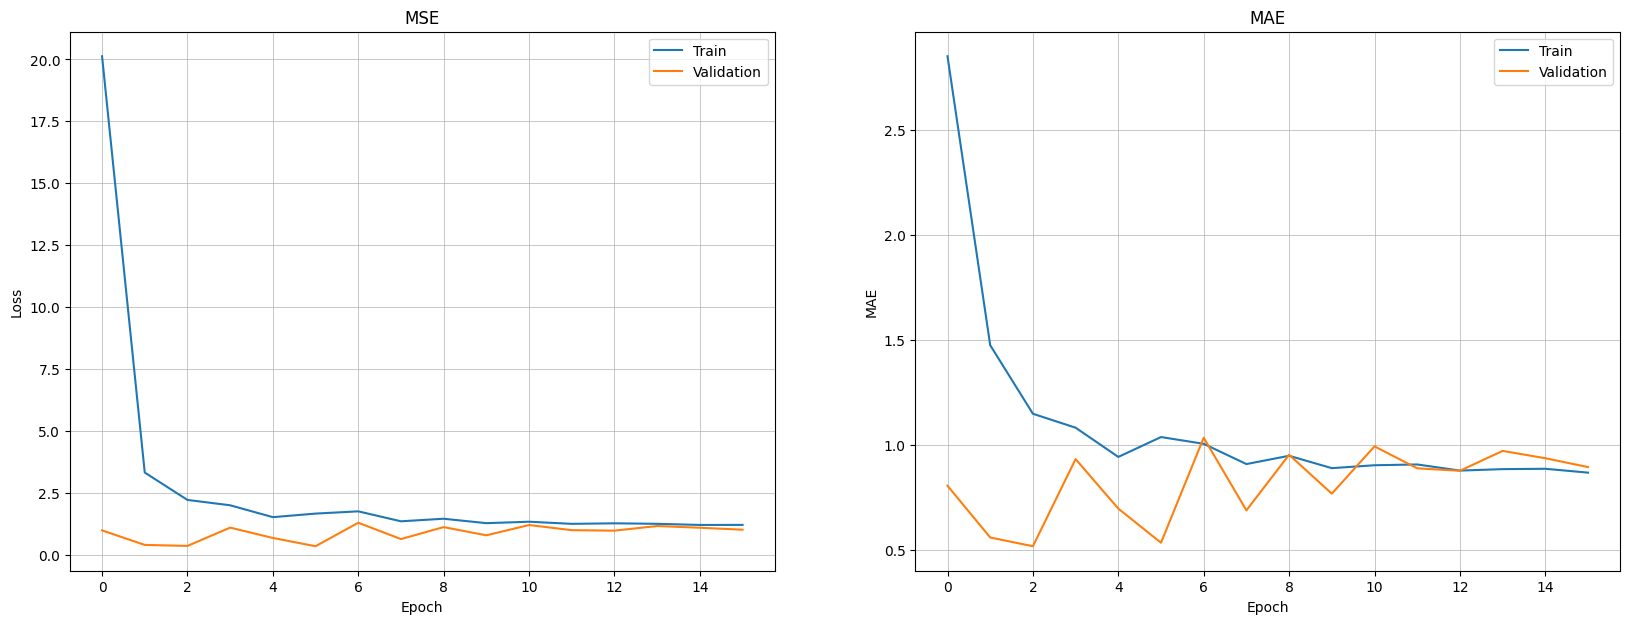

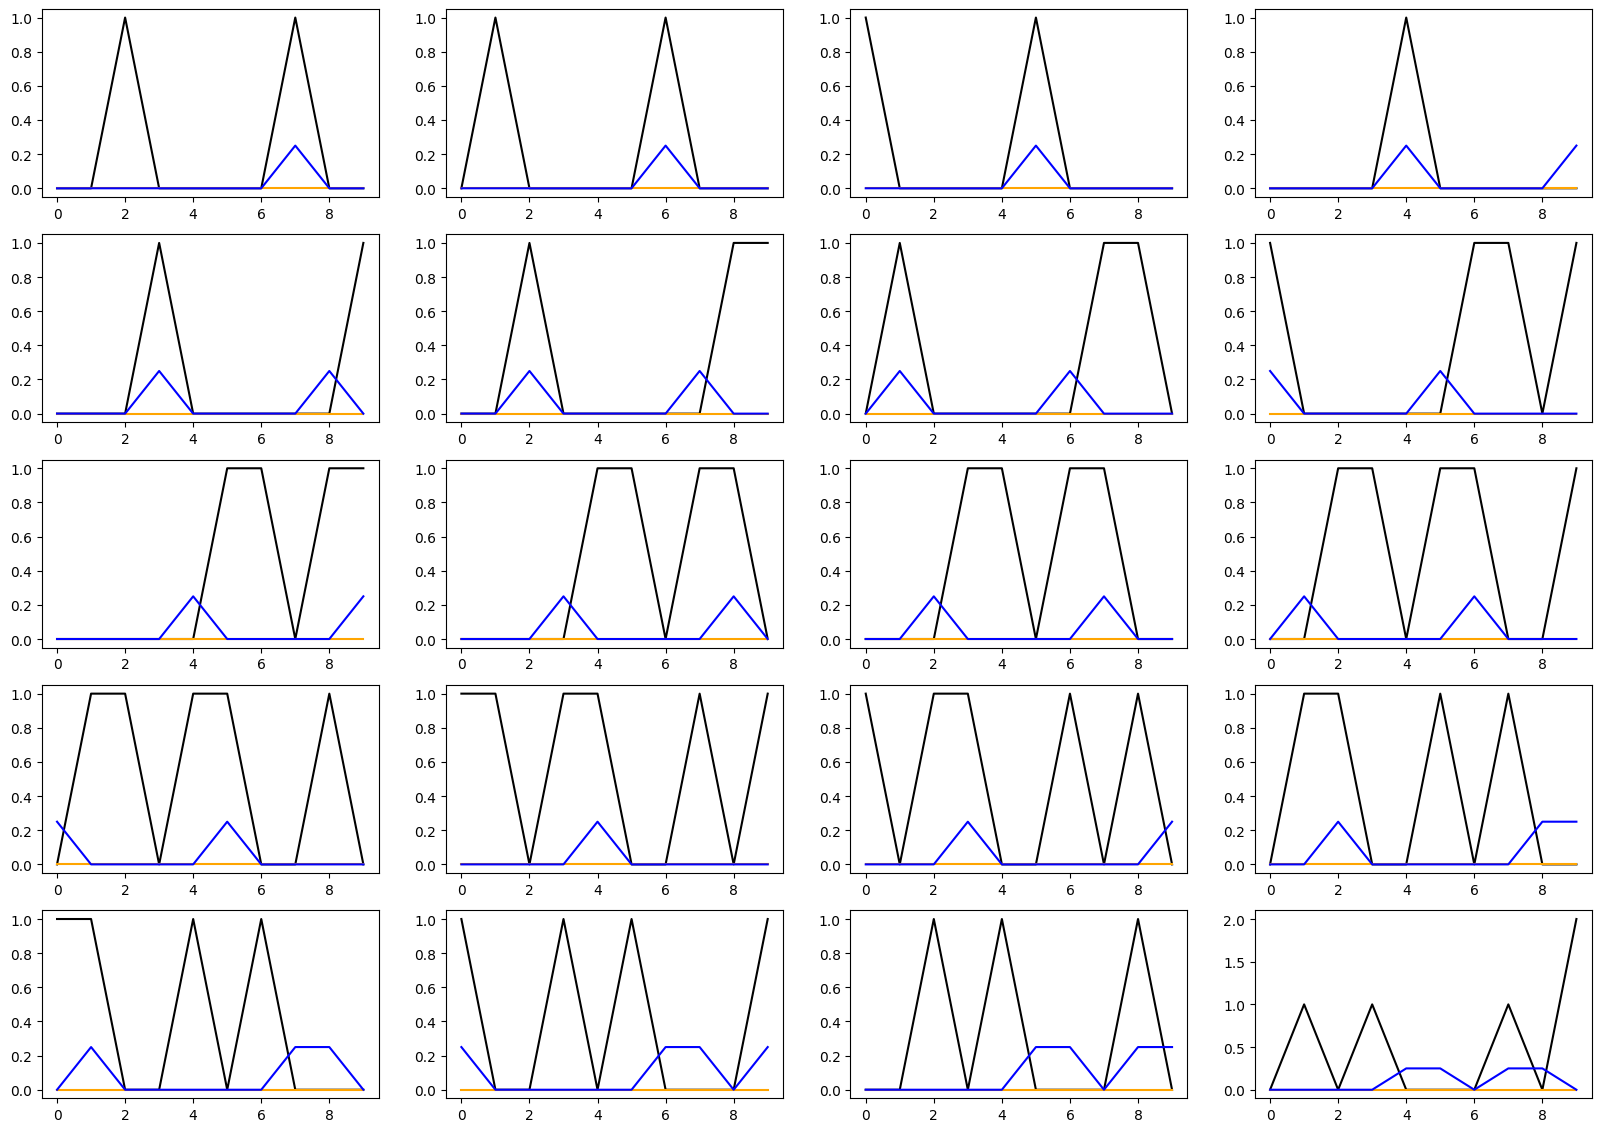

INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvj1/assets


INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpvj1/assets


******
 Initiating procedure on geohash gcpuv2
 ******
2/2 [==============================] - 0s 7ms/step - loss: 2.7338 - mae: 1.2630
The LSTM MAE on the test set is equal to 0.91 accidents
Improvement of the LSTM model over the baseline (on this fold for the test set) = :27.78 %
2/2 [==============================] - 0s 3ms/step


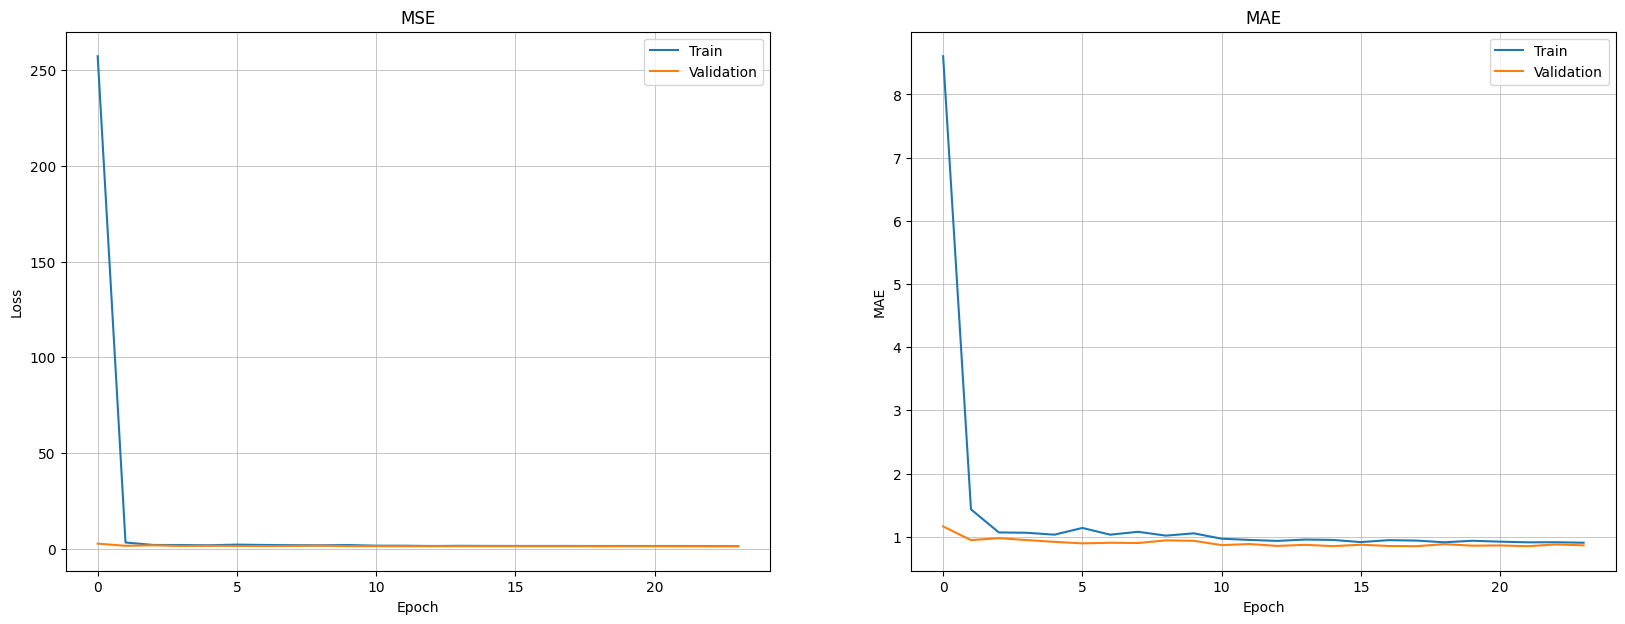

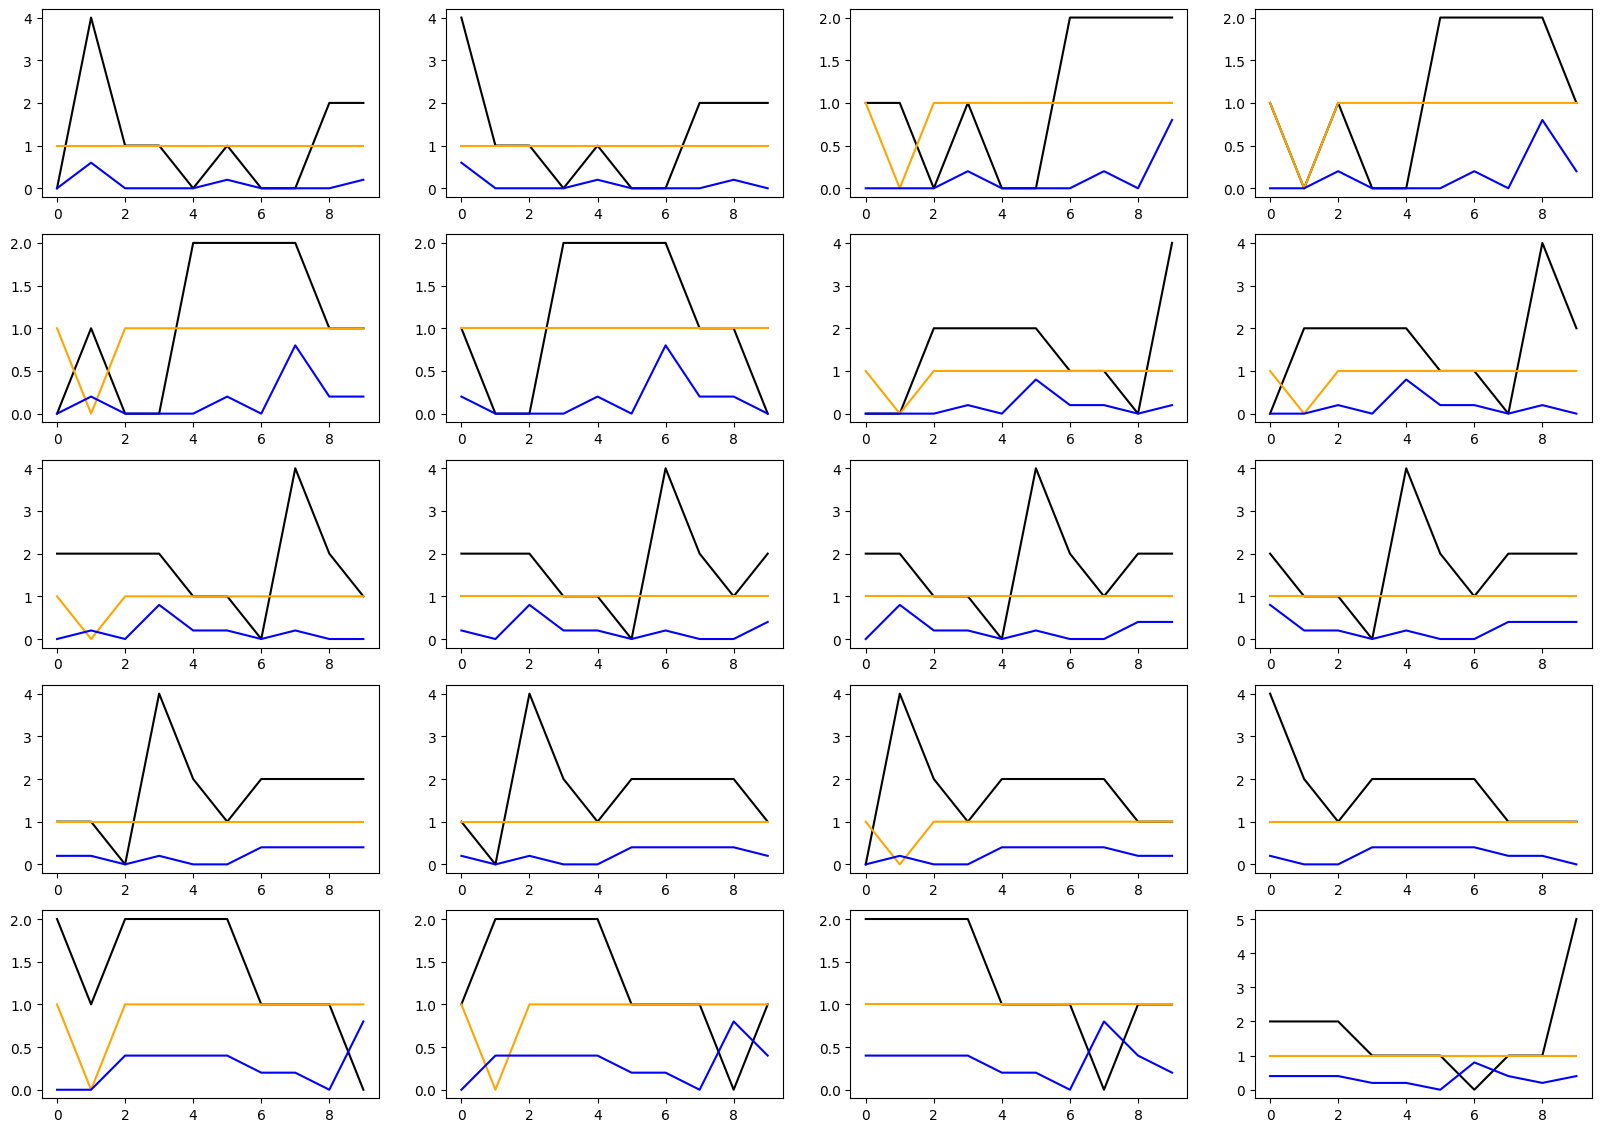

INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpuv2/assets


INFO:tensorflow:Assets written to: ../uk_road_safety/model/gcpuv2/assets


In [89]:
for hash in geohash_list:
    print(f'******\n Initiating procedure on geohash {hash}\n ******')
    #filtering the data by hash and creating the time series
    filtered_data=df_accidents[df_accidents['geohash']==hash]
    time_series=data_for_analysis(filtered_data,'W')
    #creating the folds within the time series and selecting the last fold
    folds=mlmodel.get_folds(time_series,FOLD_LENGTH,FOLD_STRIDE)
    fold=folds[-1]
    #splitting the folds in train and test and normalizing
    (fold_train, fold_test) = mlmodel.train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)
    columns=fold_train.columns
    scaler=MinMaxScaler()
    fold_train=pd.DataFrame(scaler.fit_transform(fold_train),columns=columns)
    fold_test=pd.DataFrame(scaler.transform(fold_test),columns=columns)
    #creating the sequences
    X_train_scaled, y_train_scaled = mlmodel.get_X_y_strides(fold_train,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)
    X_test_scaled, y_test_scaled = mlmodel.get_X_y_strides(fold_test,INPUT_LENGTH,OUTPUT_LENGTH,SEQUENCE_STRIDE)
    y_train=y_train_scaled
    y_test=y_test_scaled
    for i,y in enumerate(y_train_scaled):
        y_train[i]=(scaler.inverse_transform(y))
    for i,y in enumerate(y_test_scaled):
        y_test[i]=(scaler.inverse_transform(y))
    y_test=y_test.astype(int)
    y_train=y_train.astype(int) 
    #initiating and trining the model
    model = mlmodel.init_model(X_train_scaled)
    model, history = mlmodel.fit_model(model,X_train_scaled,y_train,verbose=0)
    mlmodel.plot_history(history);
    res=model.evaluate(X_test_scaled,y_test)
    #initiating the baseline model
    baseline_model = mlmodel.init_baseline(OUTPUT_LENGTH)
    baseline_score = baseline_model.evaluate(X_test_scaled, y_test)
    print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} accidents")
    print(f"Improvement of the LSTM model over the baseline (on this fold for the test set) = :{round((1 - (res[1]/baseline_score[1]))*100,2)} %")
    #generating predictions
    y_pred=model.predict(X_test_scaled)
    y_bas_pred=baseline_model.predict(X_test_scaled)
    mlmodel.plot_predictions(y_test, y_pred, y_bas_pred)
    #saving the model and the last week of 2021 for the final prediction
    model.save(f'../uk_road_safety/model/{hash}')
    X=X_test_scaled[-1]
    np.save(os.path.join('../uk_road_safety/data',f'X_{hash}.npy'), X)
    

True